# Notebook to generate tuning curve plots.

This notebook requires the processed behavior data for the ring task cached in
`../../cache/behavior/ring.csv`. See `../../behavior_processing` for details.

This notebook requires the delay phase firing rates cached in
`../../cache/phys_processing/spikes_to_trials/delay_phase_firing_rates`. See
`../../phys_processing` for details.

In [2]:
"""Imports."""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../../behavior_processing')
import load_ring_data

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [3]:
"""Constants."""

_SUBJECT = "Perle"
_DMFC_UNITS = [
    ("2022-06-11", 188),
    ("2022-06-11", 119),
    ("2022-06-11", 110),
]
_FEF_UNITS = [
    ("2022-06-11", 20),
    ("2022-06-11", 53),
    ("2022-06-11", 92),
]

In [4]:
"""Load firing rate data."""

BASE_NEURAL_DIR = Path("../../../cache/phys_processing/spikes_to_trials/delay_phase_firing_rates/")
df_behavior = load_ring_data.load_data()

dict_plot = {
    "num_objects": [],
    "firing_rate": [],
    "x": [],
    "y": [],
    "unit": [],
    "brain_area": [],
}
for brain_area, units in zip(["dmfc", "fef"], [_DMFC_UNITS, _FEF_UNITS]):
    for session, unit in units:
        # Load neural data for the unit
        neural_path = BASE_NEURAL_DIR / _SUBJECT / session / "fr.csv"
        df_neural = pd.read_csv(neural_path, index_col=0)

        # Extract behavior data for the session
        df_behavior_unit = df_behavior[
            (df_behavior.subject == _SUBJECT) & (df_behavior.session == session)
        ]
        
        print(f"Unit {unit}...")
        df_unit = df_neural[df_neural.unit == unit]
        for _, row in df_unit.iterrows():
            trial = row["trial"]
            behavior_row = df_behavior_unit[df_behavior_unit.trial_num == trial].iloc[0]
            num_objects = behavior_row["num_objects"]
            
            # Add target object
            dict_plot["num_objects"].append(num_objects)
            dict_plot["firing_rate"].append(row["firing_rate"])
            dict_plot["x"].append(behavior_row["object_0_x"] - 0.5)
            dict_plot["y"].append(behavior_row["object_0_y"] - 0.5)
            dict_plot["unit"].append(unit)
            dict_plot["brain_area"].append(brain_area)
            
            # Add distractor object if it exists
            if num_objects > 1:
                dict_plot["num_objects"].append(num_objects)
                dict_plot["firing_rate"].append(row["firing_rate"])
                dict_plot["x"].append(behavior_row["object_1_x"] - 0.5)
                dict_plot["y"].append(behavior_row["object_1_y"] - 0.5)
                dict_plot["unit"].append(unit)
                dict_plot["brain_area"].append(brain_area)
        
df_plot = pd.DataFrame(dict_plot)

Unit 188...
Unit 119...
Unit 110...
Unit 20...
Unit 53...
Unit 92...


In [5]:
"""Make dataframe of smoothed firing rates."""

dict_smooth = {
    "firing_rate": [],
    "x": [],
    "y": [],
    "unit": [],
    "brain_area": [],
}
dict_smooth_mean = {
    "firing_rate": [],
    "x": [],
    "y": [],
    "unit": [],
    "brain_area": [],
}
bootstrap_num = 100
num_points = 256
tau = 50
radius = 0.35
thetas = np.linspace(np.pi, 3 * np.pi, num_points, endpoint=False)
vertices = radius * np.array([np.cos(thetas), np.sin(thetas)]).T
for unit_index, unit in enumerate(df_plot.unit.unique()):
    eccentricity = (1 + 0.7 * (unit_index % 3))
    df_unit = df_plot[
        (df_plot.unit == unit)
        & (df_plot.num_objects == 1)
    ]
    brain_area = df_plot[df_plot.unit == unit].brain_area.values[0]
    print(f"Unit {unit}, brain area {brain_area}, eccentricity {eccentricity}...")
    firing_rate = df_unit["firing_rate"].values
    positions = np.array([df_unit["x"].values, df_unit["y"].values]).T
    
    # Update dict_smooth
    for _ in range(bootstrap_num):
        num_samples = len(firing_rate)
        num_samples = 100
        indices = np.random.choice(len(firing_rate), size=num_samples, replace=True)
        fr = firing_rate[indices]
        pos = positions[indices]
        fr_smooth = np.zeros(num_points)
        for i, vertex in enumerate(vertices):
            distances = np.linalg.norm(pos - vertex, axis=1)
            weights = np.exp(-tau * distances**2)
            weighted_fr = np.sum(fr * weights) / np.sum(weights)
            fr_smooth[i] = weighted_fr
        for i, vertex in enumerate(vertices):
            dict_smooth["firing_rate"].append(fr_smooth[i])
            dict_smooth["x"].append(eccentricity * vertex[0])
            dict_smooth["y"].append(eccentricity * vertex[1])
            dict_smooth["unit"].append(unit)
            dict_smooth["brain_area"].append(brain_area)
    
    # Update dict_smooth_mean
    for i, vertex in enumerate(vertices):
        distances = np.linalg.norm(positions - vertex, axis=1)
        weights = np.exp(-tau * distances**2)
        weighted_fr = np.sum(firing_rate * weights) / np.sum(weights)
        fr_smooth[i] = weighted_fr
    for i, vertex in enumerate(vertices):
        dict_smooth_mean["firing_rate"].append(fr_smooth[i])
        dict_smooth_mean["x"].append(eccentricity * vertex[0])
        dict_smooth_mean["y"].append(eccentricity * vertex[1])
        dict_smooth_mean["unit"].append(unit)
        dict_smooth_mean["brain_area"].append(brain_area)
        
df_smooth = pd.DataFrame(dict_smooth)
df_smooth["theta"] = np.arctan2(df_smooth["y"], df_smooth["x"])
df_smooth["theta"] = np.mod(df_smooth["theta"], 2 * np.pi)
df_smooth["unit"] = df_smooth["unit"].astype(str)

df_smooth_mean = pd.DataFrame(dict_smooth_mean)
df_smooth_mean["theta"] = np.arctan2(df_smooth_mean["y"], df_smooth_mean["x"])
df_smooth_mean["theta"] = np.mod(df_smooth_mean["theta"], 2 * np.pi)
df_smooth_mean["unit"] = df_smooth_mean["unit"].astype(str)


Unit 188, brain area dmfc, eccentricity 1.0...
Unit 119, brain area dmfc, eccentricity 1.7...
Unit 110, brain area dmfc, eccentricity 2.4...
Unit 20, brain area fef, eccentricity 1.0...
Unit 53, brain area fef, eccentricity 1.7...
Unit 92, brain area fef, eccentricity 2.4...


/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_38838/751555517.py:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_38838/751555517.py:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_38838/751555517.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


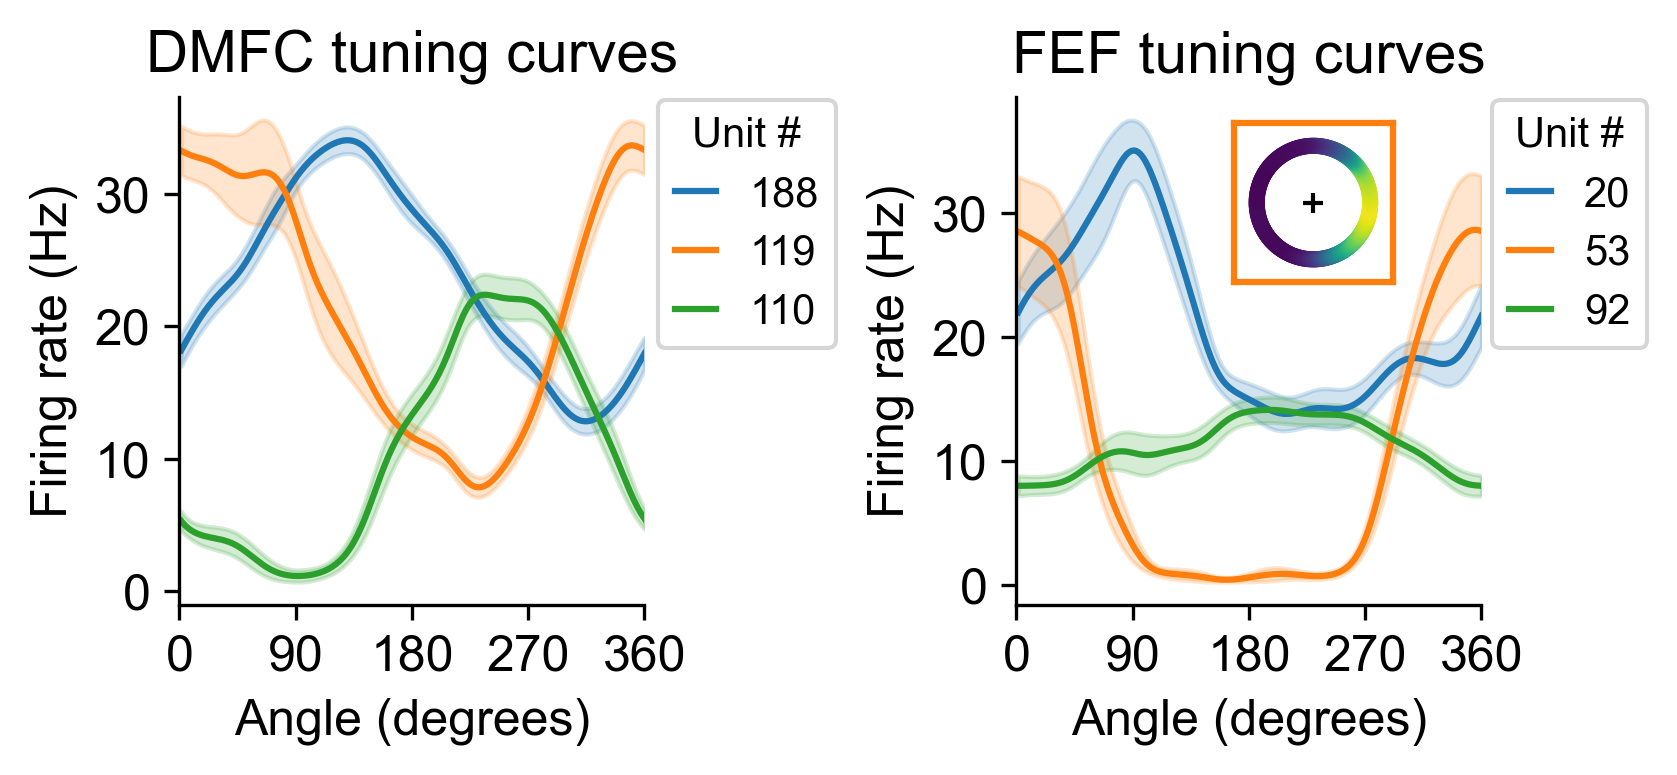

In [8]:
"""Plot data."""

palette = sns.color_palette()
fig, axes = plt.subplots(1, 2, figsize=(5.6, 2.2), gridspec_kw={"wspace": 0.8})
for ax, brain_area in zip(axes, ["dmfc", "fef"]):
    sns.despine(ax=ax)
    to_plot = df_smooth[df_smooth.brain_area == brain_area]
    sns.lineplot(
        data=to_plot,
        ax=ax,
        x="theta",
        y="firing_rate",
        hue="unit",
        errorbar="sd",
        palette=palette,
    )
    legend_x = 1.22 if brain_area == "dmfc" else 1.19
    sns.move_legend(
        ax,
        "center",
        bbox_to_anchor=(legend_x, 0.75),
        ncol=1,
        title="Unit #",
        handlelength=1,
    )
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi])
    ax.set_xticklabels(["0", "90", "180", "270", "360"])
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title(f"{brain_area.upper()} tuning curves")
    
# Add inset into lower axis
ax_inset = fig.add_axes([0.675, 0.6, 0.25, 0.24])
ax_inset.set_aspect('equal')
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_xlim(-0.83, 0.83)
ax_inset.set_ylim(-0.83, 0.83)
ax_inset.plot(0, 0, marker='+', color='black', markersize=5, markeredgewidth=1)
sns.scatterplot(
    data=df_smooth_mean[(df_smooth_mean.brain_area == brain_area) & (df_smooth_mean.unit == "53")],
    ax=ax_inset,
    x="x",
    y="y",
    hue="firing_rate",
    s=15,
    linewidth=0,
    palette="viridis",
    legend=False,
    hue_norm=plt.Normalize(0, 30),
)
for spine in ax_inset.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color(palette[1])

# Save figure
fig.tight_layout()
fig.savefig(f"tuning_curves.pdf", bbox_inches='tight', pad_inches=0.01)